In [1]:
# To install libraries
!pip3 install ultralytics matplotlib opencv-python pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 43.9 MB/s eta 0:00:00


In [2]:
# To import libraries
import os
import shutil
import json
import random
from zipfile import ZipFile
import requests
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
def create_dataset_structure(base_path):
    os.makedirs(os.path.join(base_path, "train", "images"), exist_ok=True)
    os.makedirs(os.path.join(base_path, "train", "labels"), exist_ok=True)
    os.makedirs(os.path.join(base_path, "test", "images"), exist_ok=True)
    os.makedirs(os.path.join(base_path, "test", "labels"), exist_ok=True)

dataset_path = "car_parts_dataset"
create_dataset_structure(dataset_path)

In [4]:
# To download the dataset
url = "https://github.com/dsmlr/Car-Parts-Segmentation/archive/refs/heads/master.zip"
dataset_zip = "car_parts_dataset.zip"
response = requests.get(url)

with open(dataset_zip, "wb") as file:
    file.write(response.content)

with ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

extracted_folder = "Car-Parts-Segmentation-master"
training_images = os.path.join(extracted_folder, "trainingset", "JPEGImages")
training_annotations = os.path.join(extracted_folder, "trainingset", "annotations.json")
testing_images = os.path.join(extracted_folder, "testset", "JPEGImages")
testing_annotations = os.path.join(extracted_folder, "testset", "annotations.json")

try:
    if os.path.exists(training_images):
        shutil.move(training_images, os.path.join(dataset_path, "train", "images"))
    else:
        print("Training images folder not found. Check extracted contents.")

    if os.path.exists(training_annotations):
        shutil.move(training_annotations, os.path.join(dataset_path, "train", "annotations.json"))
    else:
        print("Training annotations file not found. Check extracted contents.")

    if os.path.exists(testing_images):
        shutil.move(testing_images, os.path.join(dataset_path, "test", "images"))
    else:
        print("Testing images folder not found. Check extracted contents.")

    if os.path.exists(testing_annotations):
        shutil.move(testing_annotations, os.path.join(dataset_path, "test", "annotations.json"))
    else:
        print("Testing annotations file not found. Check extracted contents.")
except Exception as e:
    print(f"Error during file organization: {e}")


os.remove(dataset_zip)
shutil.rmtree(extracted_folder, ignore_errors=True)



print("Downloaded and organised into the Yolo required format successfully.")


Downloaded and organised into the Yolo required format successfully.


In [5]:
def move_images_and_delete_folder(src_folder, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)

    for file_name in os.listdir(src_folder):
        src_file = os.path.join(src_folder, file_name)
        dest_file = os.path.join(dest_folder, file_name)
        shutil.move(src_file, dest_file)

    # to delete the source folder
    os.rmdir(src_folder)

src_folder = "/content/car_parts_dataset/train/images/JPEGImages"
dest_folder = "/content/car_parts_dataset/train/images"
move_images_and_delete_folder(src_folder, dest_folder)

src_folder = "/content/car_parts_dataset/test/images/JPEGImages"
dest_folder = "/content/car_parts_dataset/test/images"
move_images_and_delete_folder(src_folder, dest_folder)

In [6]:
# function to convert COCO bbox to YOLO format

def coco_to_yolo(bbox, img_width, img_height):
    x, y, width, height = bbox
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width /= img_width
    height /= img_height
    return x_center, y_center, width, height

In [7]:
# to load the annotations from train and test directories

for subset in ["train", "test"]:
    subset_annotations_path = os.path.join(dataset_path, subset, "annotations.json")
    if not os.path.exists(subset_annotations_path):
        raise FileNotFoundError(f"Annotations file not found in {subset} folder: {subset_annotations_path}")

    with open(subset_annotations_path, "r") as file:
        annotations = json.load(file)

    # to parse annotations and save in YOLO format
    for img_info in annotations["images"]:
        img_id = img_info["id"]
        img_name = img_info["file_name"]
        img_width = img_info["width"]
        img_height = img_info["height"]

        # to generate YOLO label file
        yolo_label_path = os.path.join(dataset_path, subset, "labels", img_name.replace(".jpg", ".txt"))
        with open(yolo_label_path, "w") as label_file:
            for ann in annotations["annotations"]:
                if ann["image_id"] == img_id:
                    bbox = ann["bbox"]
                    category_id = ann["category_id"]
                    yolo_bbox = coco_to_yolo(bbox, img_width, img_height)
                    label_file.write(f"{category_id} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}\n")

print("Annotations parsed and converted to YOLO format successfully.")

Annotations parsed and converted to YOLO format successfully.


In [8]:
def reduce_class_ids(label_dir):
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)

        # to check if the file is a .txt file
        if os.path.isfile(label_path) and label_file.endswith('.txt'):
            with open(label_path, "r") as file:
                lines = file.readlines()

            updated_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) > 0:
                    # Reduce the class_id by 2
                    class_id = int(parts[0]) - 2
                    if class_id < 0:
                        print(f"Invalid class ID in {label_file}: {line.strip()}")
                        continue
                    updated_line = f"{class_id} " + " ".join(parts[1:]) + "\n"
                    updated_lines.append(updated_line)

            # to overwrite the label file with updated lines
            with open(label_path, "w") as file:
                file.writelines(updated_lines)
            print(f"Updated class IDs in {label_file}")

train_label_dir = "/content/car_parts_dataset/train/labels"
test_label_dir = "/content/car_parts_dataset/test/labels"

# to reduce class IDs by 2 in both training and testing directories
reduce_class_ids(train_label_dir)
reduce_class_ids(test_label_dir)

Updated class IDs in train75.txt
Updated class IDs in train61.txt
Updated class IDs in train133.txt
Updated class IDs in train335.txt
Updated class IDs in train302.txt
Updated class IDs in train56.txt
Updated class IDs in train357.txt
Updated class IDs in train43.txt
Updated class IDs in train95.txt
Updated class IDs in train262.txt
Updated class IDs in train21.txt
Updated class IDs in train202.txt
Updated class IDs in train225.txt
Updated class IDs in train333.txt
Updated class IDs in train99.txt
Updated class IDs in train153.txt
Updated class IDs in train193.txt
Updated class IDs in train63.txt
Updated class IDs in train244.txt
Updated class IDs in train82.txt
Updated class IDs in train42.txt
Updated class IDs in train322.txt
Updated class IDs in train3.txt
Updated class IDs in train130.txt
Updated class IDs in train310.txt
Updated class IDs in train352.txt
Updated class IDs in train303.txt
Updated class IDs in train214.txt
Updated class IDs in train372.txt
Updated class IDs in train

In [9]:
def split_dataset(source_dir, train_dir, val_dir, split_ratio=0.75):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    images = [f for f in os.listdir(os.path.join(source_dir, "images")) if f.endswith(".jpg")]
    random.shuffle(images)     # to shuffle the images randomly

    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]


     # moving images and labels to the train/val folders
    for image_name in train_images:
        shutil.move(os.path.join(source_dir, "images", image_name), os.path.join(train_dir, "images"))
        label_name = image_name.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(source_dir, "labels", label_name)):
            shutil.move(os.path.join(source_dir, "labels", label_name), os.path.join(train_dir, "labels"))

    for image_name in val_images:
        shutil.move(os.path.join(source_dir, "images", image_name), os.path.join(val_dir, "images"))
        label_name = image_name.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(source_dir, "labels", label_name)):
            shutil.move(os.path.join(source_dir, "labels", label_name), os.path.join(val_dir, "labels"))
source_directory = "/content/car_parts_dataset/train"
train_directory = "/content/car_parts_dataset/training_set"
validation_directory = "/content/car_parts_dataset/validation_set"

os.makedirs(os.path.join(train_directory, "images"), exist_ok=True)
os.makedirs(os.path.join(train_directory, "labels"), exist_ok=True)
os.makedirs(os.path.join(validation_directory, "images"), exist_ok=True)
os.makedirs(os.path.join(validation_directory, "labels"), exist_ok=True)
split_dataset(source_directory, train_directory, validation_directory)
print("The training dataset is split into train and validation sets successfully")

The training dataset is split into train and validation sets successfully


In [10]:
data_yaml = """

train: /content/car_parts_dataset/training_set
val: /content/car_parts_dataset/validation_set
test: /content/car_parts_dataset/test

nc: 18

names: ['back_bumper', 'back_glass', 'back_left_door', 'back_left_light',
        'back_right_door', 'back_right_light',
        'front_bumper', 'front_glass', 'front_left_door', 'front_left_light',
        'front_right_door',
        'front_right_light', 'hood', 'left_mirror', 'right_mirror', 'tailgate',
        'trunk', 'wheel']
"""

# to save the YAML configuration
with open("car_parts_dataset.yaml", "w") as file:
    file.write(data_yaml)

In [11]:
# to install Ultralytics for YOLOv8
!pip3 install ultralytics

In [12]:
from ultralytics import YOLO

# the path to the YOLOv8 configuration file
model = YOLO("yolov8s.pt")

# training YOLOv8 on our car parts dataset for 70 more epochs
results = model.train(
    data="car_parts_dataset.yaml",
    epochs=50,
    imgsz=640,
    lr0=0.01
    batch=16,
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 451MB/s]


Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=car_parts_dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 109MB/s]


Overriding model.yaml nc=80 with nc=18

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 341MB/s]


AMP: checks passed ✅


train: Scanning /content/car_parts_dataset/training_set/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 1340.93it/s]

train: New cache created: /content/car_parts_dataset/training_set/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/car_parts_dataset/validation_set/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 1464.72it/s]

val: New cache created: /content/car_parts_dataset/validation_set/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000455, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.97G      1.584      4.285      1.657        116        640: 100%|██████████| 19/19 [00:09<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

                   all        100        807       0.24      0.286      0.143     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.87G       1.16      2.481      1.306        123        640: 100%|██████████| 19/19 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        100        807      0.295        0.5      0.338      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.02G     0.9991      1.859      1.173        129        640: 100%|██████████| 19/19 [00:06<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        100        807      0.403      0.586      0.448      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.87G     0.8972      1.485        1.1        187        640: 100%|██████████| 19/19 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        100        807      0.555      0.577      0.564      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.02G     0.8814      1.383      1.092        155        640: 100%|██████████| 19/19 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        100        807      0.479      0.733      0.601      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.05G     0.8507      1.254      1.081        187        640: 100%|██████████| 19/19 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

                   all        100        807      0.535      0.777      0.626      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         4G     0.8316      1.194      1.056        134        640: 100%|██████████| 19/19 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        100        807      0.577      0.698      0.643      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.89G     0.8156      1.137      1.048        151        640: 100%|██████████| 19/19 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        100        807      0.577      0.772      0.657      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.85G      0.787      1.048      1.031        166        640: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        100        807      0.574      0.816      0.661      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.8G     0.7821     0.9943      1.023        180        640: 100%|██████████| 19/19 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        100        807      0.591      0.826      0.673       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.07G     0.7634      0.968      1.021        143        640: 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        100        807      0.593      0.826      0.691      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.02G     0.7434     0.9266      1.005        147        640: 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        100        807      0.604      0.819      0.713       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.84G     0.7069     0.8951      1.004         91        640: 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        100        807       0.63      0.808      0.706      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.01G     0.7302      0.928      1.005        141        640: 100%|██████████| 19/19 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        100        807      0.594      0.813        0.7      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.02G     0.7143     0.8835     0.9884        155        640: 100%|██████████| 19/19 [00:08<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

                   all        100        807      0.619      0.821      0.723      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.02G     0.6901      0.855     0.9762        153        640: 100%|██████████| 19/19 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        100        807      0.601      0.849      0.686       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.99G     0.6795     0.8392     0.9723        162        640: 100%|██████████| 19/19 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        100        807      0.601      0.874      0.711      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.87G     0.6847     0.8205     0.9812        126        640: 100%|██████████| 19/19 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        100        807      0.584      0.849       0.72      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.01G      0.667      0.792     0.9668        150        640: 100%|██████████| 19/19 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        100        807       0.63      0.839      0.711      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.92G     0.6568     0.7879     0.9677        162        640: 100%|██████████| 19/19 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        100        807        0.6      0.871      0.697      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.87G     0.6576     0.7791     0.9777        134        640: 100%|██████████| 19/19 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        100        807      0.594      0.891      0.706      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.03G     0.6385     0.7464     0.9703        122        640: 100%|██████████| 19/19 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        100        807      0.614      0.861      0.722      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.06G     0.6441     0.7403     0.9629        161        640: 100%|██████████| 19/19 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        100        807       0.64      0.852      0.725      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.87G     0.6239      0.727     0.9499        160        640: 100%|██████████| 19/19 [00:06<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        100        807      0.589      0.876      0.687      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.86G     0.6243     0.6974     0.9593        188        640: 100%|██████████| 19/19 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        100        807      0.626       0.85      0.711      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.02G      0.617     0.6724      0.945        171        640: 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        100        807      0.653      0.822      0.741      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.93G     0.6234     0.6771     0.9602        139        640: 100%|██████████| 19/19 [00:05<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        100        807      0.632       0.86      0.754      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.06G     0.5954     0.6442     0.9513        123        640: 100%|██████████| 19/19 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        100        807      0.646      0.824      0.745      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.84G     0.6036     0.6444     0.9495        179        640: 100%|██████████| 19/19 [00:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

                   all        100        807      0.655      0.735      0.721      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.87G     0.5939     0.6283     0.9379        203        640: 100%|██████████| 19/19 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        100        807      0.608      0.793      0.703      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.07G     0.5748     0.5881     0.9278        153        640: 100%|██████████| 19/19 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

                   all        100        807      0.671       0.81      0.743      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.05G      0.584     0.5847      0.944        197        640: 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        100        807      0.688      0.809      0.761       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.98G     0.5592      0.574     0.9333        106        640: 100%|██████████| 19/19 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        100        807       0.67      0.802      0.751      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.03G     0.5657     0.5737     0.9315        134        640: 100%|██████████| 19/19 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        100        807      0.668      0.789      0.733      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.89G     0.5761     0.5732     0.9277        172        640: 100%|██████████| 19/19 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]

                   all        100        807      0.655      0.828      0.746      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.07G      0.574     0.5642     0.9369        160        640: 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        100        807      0.706       0.79      0.764      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.98G     0.5459     0.5357     0.9258        163        640: 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]

                   all        100        807      0.709      0.801      0.773      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.87G      0.556     0.5298     0.9272        128        640: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        100        807       0.68      0.832      0.762      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.88G     0.5436     0.5204     0.9176        138        640: 100%|██████████| 19/19 [00:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        100        807      0.677      0.826      0.771      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.03G      0.553     0.5112     0.9295        142        640: 100%|██████████| 19/19 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all        100        807      0.685      0.803      0.777      0.631


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.92G     0.5096     0.4569     0.8847         84        640: 100%|██████████| 19/19 [00:09<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        100        807      0.679      0.763      0.751      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       4.1G     0.4922     0.4261     0.8794         91        640: 100%|██████████| 19/19 [00:05<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        100        807      0.657      0.784       0.74      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.94G      0.484     0.4158     0.8727         91        640: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        100        807      0.653      0.822      0.755      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.03G     0.4778     0.4118     0.8705         92        640: 100%|██████████| 19/19 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

                   all        100        807      0.651      0.812      0.755      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.06G     0.4766     0.3923     0.8655         94        640: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        100        807      0.677      0.794      0.767      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.08G     0.4679      0.382     0.8672         96        640: 100%|██████████| 19/19 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

                   all        100        807      0.692        0.8      0.778      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.94G     0.4677     0.3834     0.8738         89        640: 100%|██████████| 19/19 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        100        807      0.713      0.819        0.8      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.94G     0.4577     0.3722      0.861         88        640: 100%|██████████| 19/19 [00:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

                   all        100        807      0.714      0.806      0.798      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.06G     0.4509     0.3608     0.8514         86        640: 100%|██████████| 19/19 [00:08<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

                   all        100        807       0.71      0.779      0.785      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.09G      0.442     0.3628     0.8653         90        640: 100%|██████████| 19/19 [00:05<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        100        807      0.698      0.793      0.776      0.641



50 epochs completed in 0.130 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,132,550 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


                   all        100        807      0.712      0.817      0.801       0.66
           back_bumper         24         24      0.923      0.917      0.942      0.803
            back_glass         24         24      0.679      0.883      0.902      0.771
        back_left_door         32         32      0.611      0.781      0.783      0.671
       back_left_light         35         35      0.525        0.8      0.581      0.426
       back_right_door         29         29      0.674      0.713      0.713      0.585
      back_right_light         26         26      0.505      0.668      0.511      0.379
          front_bumper         63         63      0.935      0.952      0.965      0.858
           front_glass         61         61      0.937       0.98      0.984      0.911
       front_left_door         34         34      0.658      0.853      0.812      0.744
      front_left_light         61         61      0.751      0.738      0.825       0.62
      front_right_doo

In [13]:
model.save("yolov8_car_parts.pt")

In [14]:
# to evaluate the model on the test set
metrics = model.val(data="car_parts_dataset.yaml")
print(metrics.maps)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,132,550 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/car_parts_dataset/validation_set/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


                   all        100        807      0.714      0.818      0.801       0.66
           back_bumper         24         24      0.924      0.917      0.942       0.79
            back_glass         24         24      0.679      0.881      0.902      0.771
        back_left_door         32         32      0.633      0.809      0.783      0.671
       back_left_light         35         35      0.525        0.8      0.573      0.428
       back_right_door         29         29      0.673       0.71      0.712      0.583
      back_right_light         26         26      0.504      0.664      0.511      0.379
          front_bumper         63         63      0.935      0.952      0.964      0.859
           front_glass         61         61      0.937      0.979      0.984      0.911
       front_left_door         34         34      0.658      0.853      0.813      0.746
      front_left_light         61         61      0.752      0.738      0.824      0.621
      front_right_doo

In [15]:
print("mAP@[IoU=50]:", metrics.maps[0])  # to check for the mAP50
print("mAP@[IoU=50:95]:", metrics.maps[1])  # to check for the mAP50-95

mAP@[IoU=50]: 0.7897247299805874
mAP@[IoU=50:95]: 0.7706447252543869



image 1/1 /content/car_parts_dataset/test/images/te39.jpg: 448x640 1 back_right_door, 1 front_bumper, 1 front_glass, 1 front_left_light, 1 front_right_door, 1 front_right_light, 1 hood, 1 right_mirror, 1 wheel, 45.7ms
Speed: 2.8ms preprocess, 45.7ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


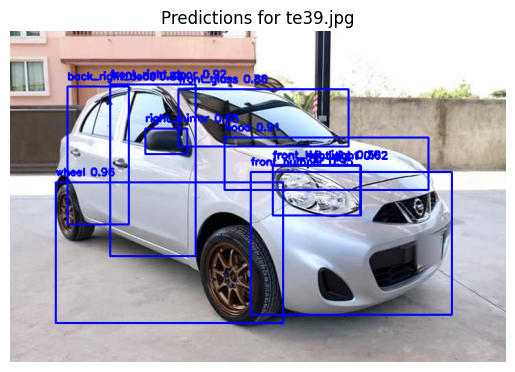


image 1/1 /content/car_parts_dataset/test/images/te21.jpg: 448x640 1 back_bumper, 1 back_glass, 1 back_left_door, 1 front_left_door, 1 front_left_light, 2 left_mirrors, 1 trunk, 1 wheel, 13.1ms
Speed: 4.0ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


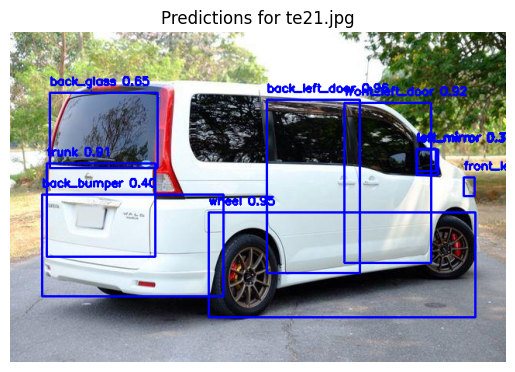

In [16]:
# to select two random test images
test_images_path = "car_parts_dataset/test/images"
test_images = os.listdir(test_images_path)
random_images = random.sample(test_images, 2)

for img_name in random_images:
    img_path = os.path.join(test_images_path, img_name)
    results = model(img_path)

    # to plot the image with bounding boxes
    img = cv2.imread(img_path)
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # to get bounding box coordinates
        conf = box.conf[0]  # to get the Confidence score
        cls = int(box.cls[0])  # to get the Class ID
        label = f"{model.names[cls]} {conf:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predictions for {img_name}")
    plt.axis("off")
    plt.show()

In [17]:
# to analyze class-wise performance
difficult_classes = {}

for result in results:
    for box in result.boxes:
        cls = int(box.cls[0])  # Class ID
        if cls not in difficult_classes:
            difficult_classes[cls] = 0
        if box.conf[0] < 0.5:  # Confidence threshold
            difficult_classes[cls] += 1

# to print classes with high localization difficulty
print("The classes with high localization difficulty are: ", difficult_classes)

The classes with high localization difficulty are:  {2: 0, 17: 0, 8: 0, 16: 0, 13: 1, 1: 0, 0: 1, 9: 1}
